In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
from helpers import *
import csv

%load_ext autoreload
%autoreload 2

## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "47b05e70-6076-44e8-96da-2530dc2187de_data_train.csv"
path_submission = "9b4d32bb-f99a-466f-95a1-0ab80048971c_sample_submission (2).csv"
ratings = load_data(path_dataset)
submission = load_submission(path_submission)
submission_row_col = submission[0]
submission_pos = submission[1]
print(ratings.shape)
print(submission_pos[0])

number of items: 10000, number of users: 1000
(10000, 1000)
r37_c1


### Plot the number of ratings per movie and user

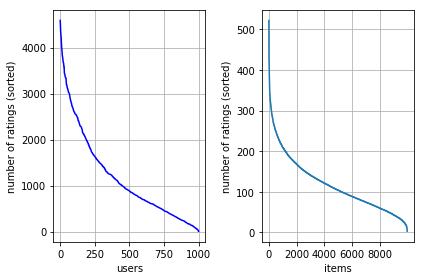

min # of items per user = 8, min # of users per item = 3.


In [3]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [4]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= min_num_ratings)[0]
    valid_items = np.where(num_users_per_item >= min_num_ratings)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

In [5]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=30, p_test=0.1)

#plot_train_test_data(train, test)

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (9648, 996)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1058391
Total number of nonzero elements in test data:110861


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [6]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
        
    num_item, num_user = train.get_shape()

    user_features = np.random.rand(num_features, num_user)
    item_features = np.random.rand(num_features, num_item)
    user_bias = np.random.rand(num_user)
    item_bias = np.random.rand(num_item)

    # start by item features.
    item_nnz = train.getnnz(axis=1)
    item_sum = train.sum(axis=1)

    for ind in range(num_item):
        item_features[0, ind] = item_sum[ind, 0] / item_nnz[ind]
        
    # then user features.
    user_nnz = train.getnnz(axis=0)
    user_sum = train.sum(axis=0)
    
    for ind in range(num_user):
        user_features[0, ind] = user_sum[0, ind] / user_nnz[ind]
        
    # intialize bias
    user_bias = user_features[0,:]
    item_bias = item_features[0,:]
        
    return user_features, item_features, user_bias, item_bias

Compute the cost by the method of matrix factorization.


In [7]:
def compute_error(data, user_features, item_features, user_bias, item_bias, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    mse = 0
    for row, col in nz:
        item_info = item_features[:, row]
        user_info = user_features[:, col]
        item_deviation = item_bias[row]
        user_deviation = user_bias[col]
        mse += (data[row, col] - (user_info.T.dot(item_info) + item_deviation + user_deviation)) ** 2
    return np.sqrt(1.0 * mse / len(nz))

In [57]:
def matrix_factorization_SGD(train, test,gamma,lambda_user,lambda_item,num_features):
    """matrix factorization by SGD."""
    
    # define parameters
    num_epochs = 10     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(348)

    # init matrix
    user_features, item_features, user_bias, item_bias = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    
    # Global mean
    nb_nz_row, nb_nz_col = np.nonzero(train)
    global_mean = np.sum(train)/len(nb_nz_row)
    print(global_mean)
    
    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma *= 0.9
        
        for d, n in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            item_deviation = item_bias[d]
            user_deviation = user_bias[n]
            err = train[d, n] - user_info.T.dot(item_info) - item_deviation - user_deviation
    
            # calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)
            item_bias[d] += gamma * (err  - lambda_item * (item_deviation + user_deviation - global_mean))
            user_bias[n] += gamma * (err  - lambda_item * (item_deviation + user_deviation - global_mean))
            
        rmse = compute_error(train, user_features, item_features, user_bias, item_bias, nz_train)
        print("iter: {}, RMSE on training set: {}.".format(it, rmse))
        
        errors.append(rmse)

    # evaluate the test error
    rmse = compute_error(test, user_features, item_features, user_bias, item_bias, nz_test)
    print("RMSE on test data: {}.".format(rmse))
    
    # output the resulting matrices
    return user_features, item_features, user_bias, item_bias   

In [59]:
#    for lambda_user in np.logspace(-2,0.5,20):
#        for lambda_item in np.logspace(-2,2,20):
#            print(lambda_user,' ', lambda_item)
lambda_user = 0.1
lambda_item = 0.7
matrix_factorization_SGD(train, test,0.01,lambda_user,lambda_item,100)

3.8581384384409922
learn the matrix factorization using SGD...
iter: 0, RMSE on training set: 1.0286607029433215.
iter: 1, RMSE on training set: 1.0190576072357083.
iter: 2, RMSE on training set: 1.0214496921817775.
iter: 3, RMSE on training set: 1.0219489588427666.
iter: 4, RMSE on training set: 1.0217099340505864.
iter: 5, RMSE on training set: 1.0203595025825858.
iter: 6, RMSE on training set: 1.018282108788884.
iter: 7, RMSE on training set: 1.0157484799905827.
iter: 8, RMSE on training set: 1.0149182966193901.
iter: 9, RMSE on training set: 1.0133924448638465.
RMSE on test data: 1.022628713853835.


(array([[ 2.79009397,  2.87421156,  2.88324905, ...,  2.72645428,
          2.77180462,  2.98497033],
        [-0.0082186 , -0.03982781, -0.04628527, ..., -0.05249356,
         -0.05080587, -0.04070631],
        [-0.00337276, -0.02267554, -0.03570365, ..., -0.15903818,
         -0.07304094, -0.03848556],
        ...,
        [-0.14601739, -0.03173159, -0.03602607, ..., -0.03144841,
         -0.07655049, -0.04038613],
        [-0.0796876 ,  0.0197385 , -0.00509334, ..., -0.03835924,
         -0.05113361, -0.0483376 ],
        [-0.1198034 , -0.01561398, -0.04645359, ..., -0.09121684,
         -0.08725146, -0.03554643]]),
 array([[0.21905725, 0.15189221, 0.23020002, ..., 0.28071802, 0.23356071,
         0.25410895],
        [0.00989555, 0.03289688, 0.01391828, ..., 0.15866763, 0.03974281,
         0.00799546],
        [0.01156577, 0.02607696, 0.0080235 , ..., 0.19488877, 0.01626126,
         0.02152415],
        ...,
        [0.01156523, 0.05031694, 0.016998  , ..., 0.21817164, 0.01353485

# Create Submission

In [ ]:
def predict(submission_row_col, user_features, item_features,user_bias,item_bias):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    predictions = []
    for row, col in submission_row_col:
        item_info = item_features[:, row-1]
        user_info = user_features[:, col-1]
        item_deviation = item_bias[row-1]
        user_deviation = user_bias[col-1]
        value_pred = user_info.T.dot(item_info) + item_deviation + user_deviation
        if value_pred < 1:
            value_pred = 1
        elif value_pred > 5:
            value_pred = 5
        else:
            value_pred = round(value_pred)
        predictions.append(value_pred) 
    return predictions

In [ ]:
def matrix_factorization_SGD(train):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = 96   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = 20     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features, user_bias, item_bias = init_MF(train, num_features)
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))
    
    # Global mean
    nb_nz_row, nb_nz_col = np.nonzero(train)
    global_mean = np.sum(train)/len(nb_nz_row)
    print(global_mean)

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train:
            # update W_d (item_features[:, d]) and Z_n (user_features[:, n])
            item_info = item_features[:, d]
            user_info = user_features[:, n]
            item_deviation = item_bias[d]
            user_deviation = user_bias[n]
            err = train[d, n] - user_info.T.dot(item_info) - item_deviation - user_deviation
    
            # calculate the gradient and update
            item_features[:, d] += gamma * (err * user_info - lambda_item * item_info)
            user_features[:, n] += gamma * (err * item_info - lambda_user * user_info)
            item_bias[d] += gamma * (err  - lambda_item * (item_deviation + user_deviation - global_mean))
            user_bias[n] += gamma * (err  - lambda_item * (item_deviation + user_deviation - global_mean))

    
    # output the resulting matrices
    return user_features, item_features, user_bias, item_bias   

user_features, item_features, user_bias, item_bias = matrix_factorization_SGD(ratings)   

In [ ]:
ratings_pred = predict(submission_row_col, user_features, item_features,user_bias,item_bias)
create_csv_submission(submission_pos, ratings_pred, "pred_sgd")